参考: https://qiita.com/sugulu_Ogawa_ISID/items/697bd03499c1de9cf082

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

print(torch.__version__)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

e:\anaconda_env\nlp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.11.0+cu113


device(type='cuda')

In [2]:
train_df = pd.read_csv("train_eval.tsv", sep="\t",  names=('text', 'label'))
test_df = pd.read_csv("test.tsv", sep="\t",  names=('text', 'label'))

test_df.head

<bound method NDFrame.head of                                                    text  label
0     Peachyでも大人気の「恋愛」をテーマにした記事の週間ランキングです！2012年6月21日...      5
1     値下げや利用可能国が拡大！テレコムスクエアは1日、ポストペイドタイプの海外向けSIMカード「...      6
2     ４月。新しい年度を迎え、新しい顧客の開拓、新しい取引先、新しい上司や同僚。エネルギーに満ち溢...      3
3     Xperia GXが発表！ソニーモバイルコミュニケーションズは9日、国内向けとして2012年...      6
4     1月も後半に入り、バレンタインデーの話題も増えてきた今日この頃。皆さんはチョコを贈る相手、決...      5
...                                                 ...    ...
1470  今週末26日、さいたまスーパーアリーナで開催される世界最高峰の総合格闘技イベント＝UFC日本...      7
1471  名番組「突撃！隣の晩ごはん」のヨネスケが、今度は「OLの昼ごはん」をレポートする。華やかな企...      0
1472  新年度を迎え、周りの環境も変わると、職場や取引先でも新しい出会いが増えるこの季節。名刺交換中...      5
1473  5日深夜、アルガルベカップで、宿敵アメリカ代表からはじめて勝利を挙げたサッカー女子日本代表＝...      7
1474  「男子厨房に入らず」—。「弁当男子」なんて言葉も登場している現代では、死語と言えるだろう。で...      0

[1475 rows x 2 columns]>

In [3]:
# データのカウント
label_list = train_df["label"].unique()
train_df["label"].value_counts() + test_df["label"].value_counts()


0    871
1    871
2    865
3    512
4    871
5    843
6    871
7    901
8    771
Name: label, dtype: int64

In [4]:
train_df, valid_df = train_test_split(train_df, test_size=0.2, shuffle=False)

In [5]:
import torch
from transformers import AdamW, AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification
from transformers import ElectraTokenizer, ElectraForSequenceClassification, BertJapaneseTokenizer
# model_path = "cl-tohoku/bert-base-japanese"
model_path = "izumi-lab/electra-base-japanese-discriminator"
# model_path = "izumi-lab/electra-small-japanese-fin-discriminator"


In [6]:
tokenizer = BertJapaneseTokenizer.from_pretrained(model_path)
model = ElectraForSequenceClassification.from_pretrained(model_path, num_labels=len(label_list))
model

Some weights of the model checkpoint at izumi-lab/electra-base-japanese-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at izumi-lab/electra-base-japanese-discriminator and are newly ini

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(32768, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [8]:
max_len = 512
# train_encoding = tokenizer(train_df["text"].to_list(), return_tensors="pt",padding=True, truncation=True, max_length=max_len)
# valid_encoding = tokenizer(valid_df["text"].to_list(), return_tensors="pt",padding=True, truncation=True, max_length=max_len)
test_encoding = tokenizer(test_df["text"].to_list(), return_tensors="pt",padding=True, truncation=True, max_length=max_len)

In [11]:
text = "今日もいい天気ですね"
test_encoding = tokenizer(text, return_tensors="pt",padding=True, truncation=True, max_length=9)

{'input_ids': tensor([[    1, 14041,   754, 13335, 21120, 13465,   733,     2]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [13]:
tokenizer.decode(test_encoding.input_ids)
print(test_encoding)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'list'

In [9]:
train_label = torch.tensor(train_df["label"].to_list())
valid_label = torch.tensor(valid_df["label"].to_list())
test_label = torch.tensor(test_df["label"].to_list())

In [11]:
class CreateDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__( self, idx):
        item = {key:torch.tensor(val[idx]).clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).clone().detach()
        return item
    
    def __len__( self):
        return len(self.labels)

# train_dataset = CreateDataset(train_encoding, train_label)
# val_dataset = CreateDataset(valid_encoding, valid_label)
test_dataset = CreateDataset(test_encoding, test_label)


In [12]:
def saveModel(): 
    path = "./IzumiElectraModel.pth" 
    torch.save(model.state_dict(), path)



In [30]:
# modelをloadする場合
model = ElectraForSequenceClassification.from_pretrained(model_path, num_labels=len(label_list))
#model.load_state_dict(torch.load('model/IzumiElectraModel.pth'))


Some weights of the model checkpoint at izumi-lab/electra-base-japanese-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at izumi-lab/electra-base-japanese-discriminator and are newly ini

In [29]:
model = model.to(device)
model.eval()
preds = []
test_label = test_df["label"].to_list()

hidden_vec = None

with torch.no_grad():
    for words in tqdm(test_df["text"].to_list()[:10]):
        text = "".join(words)
        inputs = tokenizer.encode(text, return_tensors="pt",padding=True, truncation=True, max_length=max_len).to(device)
        
        outputs = model(inputs, output_hidden_states = True)

        logits = outputs.logits
        #for hidden_vec in outputs.hidden_states:
        #    print(hidden_vec)
        print(outputs.hidden_states[12])

        pred=logits.argmax(1).item()
        preds.append(pred)
        print(logits)
        

 80%|████████  | 8/10 [00:00<00:00, 37.70it/s]

tensor([[[-0.3840, -0.1315,  0.0129,  ...,  0.3004, -0.2317,  0.6366],
         [-0.3840, -0.1315,  0.0129,  ...,  0.3004, -0.2317,  0.6366],
         [-0.3840, -0.1315,  0.0129,  ...,  0.3004, -0.2317,  0.6366],
         ...,
         [-0.3840, -0.1315,  0.0129,  ...,  0.3004, -0.2317,  0.6366],
         [-0.3840, -0.1315,  0.0129,  ...,  0.3004, -0.2317,  0.6366],
         [-0.3840, -0.1315,  0.0129,  ...,  0.3004, -0.2317,  0.6366]]],
       device='cuda:0')
tensor([[ 0.2023,  0.2331,  0.2523, -0.3434,  0.2608,  0.1914,  0.2062,  0.2314,
          0.0790]], device='cuda:0')
tensor([[[-0.3840, -0.1315,  0.0129,  ...,  0.3004, -0.2317,  0.6366],
         [-0.3840, -0.1315,  0.0129,  ...,  0.3004, -0.2317,  0.6366],
         [-0.3840, -0.1315,  0.0129,  ...,  0.3004, -0.2317,  0.6366],
         ...,
         [-0.3840, -0.1315,  0.0129,  ...,  0.3004, -0.2317,  0.6366],
         [-0.3840, -0.1315,  0.0129,  ...,  0.3004, -0.2317,  0.6366],
         [-0.3840, -0.1315,  0.0129,  ...,  0.3

100%|██████████| 10/10 [00:00<00:00, 37.79it/s]

tensor([[[-0.3840, -0.1315,  0.0129,  ...,  0.3004, -0.2317,  0.6366],
         [-0.3840, -0.1315,  0.0129,  ...,  0.3004, -0.2317,  0.6366],
         [-0.3840, -0.1315,  0.0129,  ...,  0.3004, -0.2317,  0.6366],
         ...,
         [-0.3840, -0.1315,  0.0129,  ...,  0.3004, -0.2317,  0.6366],
         [-0.3840, -0.1315,  0.0129,  ...,  0.3004, -0.2317,  0.6366],
         [-0.3840, -0.1315,  0.0129,  ...,  0.3004, -0.2317,  0.6366]]],
       device='cuda:0')
tensor([[ 0.2023,  0.2331,  0.2523, -0.3434,  0.2608,  0.1914,  0.2062,  0.2314,
          0.0790]], device='cuda:0')
tensor([[[-0.3840, -0.1315,  0.0129,  ...,  0.3004, -0.2317,  0.6366],
         [-0.3840, -0.1315,  0.0129,  ...,  0.3004, -0.2317,  0.6366],
         [-0.3840, -0.1315,  0.0129,  ...,  0.3004, -0.2317,  0.6366],
         ...,
         [-0.3840, -0.1315,  0.0129,  ...,  0.3004, -0.2317,  0.6366],
         [-0.3840, -0.1315,  0.0129,  ...,  0.3004, -0.2317,  0.6366],
         [-0.3840, -0.1315,  0.0129,  ...,  0.3

In [ ]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

for i in range(len(outputs.hidden_states)-1):
    a = outputs.hidden_states[i][0]
    b = outputs.hidden_states[i+1][0]
    print(a)

outputs.hidden_states[0].shape


tensor([[-4.9013e-02, -3.5269e-02,  3.9659e-05,  ..., -4.5948e-02,
         -5.1169e-02, -1.7002e-01],
        [-6.6065e-02, -3.8552e-01,  1.0820e-01,  ..., -5.2016e-02,
         -1.9668e-01,  2.3539e-01],
        [ 1.8220e-01,  7.4448e-01,  9.0461e-02,  ..., -2.4467e-01,
         -2.3794e-01,  1.9124e-01],
        ...,
        [-1.6205e-01, -1.1602e-01, -4.9651e-01,  ..., -2.6800e-01,
          5.5364e-02,  1.4741e-01],
        [ 3.9453e-01, -4.0082e-01,  1.1155e+00,  ..., -1.1503e-01,
          1.7212e-01, -2.8380e-02],
        [ 1.0411e-01,  1.3888e-01,  1.5240e-01,  ...,  1.1176e-01,
         -1.4519e-01,  2.2238e-01]], device='cuda:0')
tensor([[ 0.0055, -0.0092, -0.0402,  ..., -0.0080, -0.0490, -0.0393],
        [-0.0518, -0.4100,  0.1989,  ..., -0.0458, -0.1217,  0.1962],
        [ 0.2088,  0.8276,  0.2504,  ..., -0.2981, -0.1843,  0.0903],
        ...,
        [-0.1146, -0.0640, -0.1977,  ..., -0.0841,  0.1103,  0.1282],
        [ 0.3769, -0.5215,  1.1141,  ..., -0.1183,  0.2924

torch.Size([1, 100, 768])

In [ ]:
test_df["text"].to_list()[:2]

['Peachyでも大人気の「恋愛」をテーマにした記事の週間ランキングです！2012年6月21日〜6月27日の間にPeachyのアプリでみんなが読んだ恋愛記事TOP5をお届けします。第1位：「付き合おう」って言葉は必要？「好きです！付き合ってください！」「ありがとう。よろしくお願いします」…そんなやり取りがあれば一番わかりやすいんですが、なんとな〜くの流れでいつのまにか付き合っているってカップルも多いですよね。今回のお悩みは、そんなあいまいな始まりに不安を抱える女性から。「カレ攻略 恋の相談室」サイトの監修者・如月音流さんが回答してくれました。第2位：好みのタイプなんだけど…「好きだけど、愛せない女」の特徴5選好きと愛しているは違うの？そんな疑問が浮かび、周囲の男性にその違いを聞いてみることにしました。そこで男性が語った「好きな女」と「愛したい女」の違いが興味深かったのでご紹介いたします。第3位：気になる彼はどう？実は落としにくい男性の職業10個【前編】気になる人が出来たらもちろんアピールをして、付き合えるように作戦を立てたりしますよね。しかし、どんなにこちらが気のある素振りを見せてもなかなかうまくいかない人もいます。「その人がどういった職業についているのかで、大まかな性格や落としにくさわかる場合もあります」こう語るのは、元キャバクラ嬢でライターの竹内レイさん。そんなレイさんに今回は、実は落としにくい男性の職業について伺ってみたいと思います。第4位：絶対に無理！飲み会で男にドン引きされる女のNG行動7つ合コンや会社の付き合いで飲みに行く機会は意外と多いですよね。ついつい油断して飲み過ぎてしまい、だらしない姿を男性に見られてしまったことはありませんか？そこで仕事柄、アイドルや女優、女性スタッフと飲みに行く機会の多い放送作家の白武ときおさんに、どんな女性がNGなのかを伺いました。第5位：人間界ではありえない!? 自然界における驚愕の「性事情」動物たちは子孫繁栄のために繁殖活動を行います。ただ、その方法は人間のセックスと違うことも多いようです。例えば、カマキリは交尾直後にメスがオスを食べてしまうことで有名ですよね。このような驚きの性事情を、動物行動学を研究している京都女子大学現代社会学部の中田兼介准教授に教えてもらいました。さっそく紹介していきましょう。以上、先週のPea

In [22]:
correct_cnt = 0
for pred, ans in zip(preds, test_label):
    if pred == ans:
        correct_cnt += 1 # 正解 率（ ＝ 全 データ の うち 正解 が どれ だけか)
print( correct_cnt/ len(test_label))

0.1288135593220339


カテゴリー数: 9
['dokujo-tsushin', 'it-life-hack', 'kaden-channel', 'livedoor-homme', 'movie-enter', 'peachy', 'smax', 'sports-watch', 'topic-news']


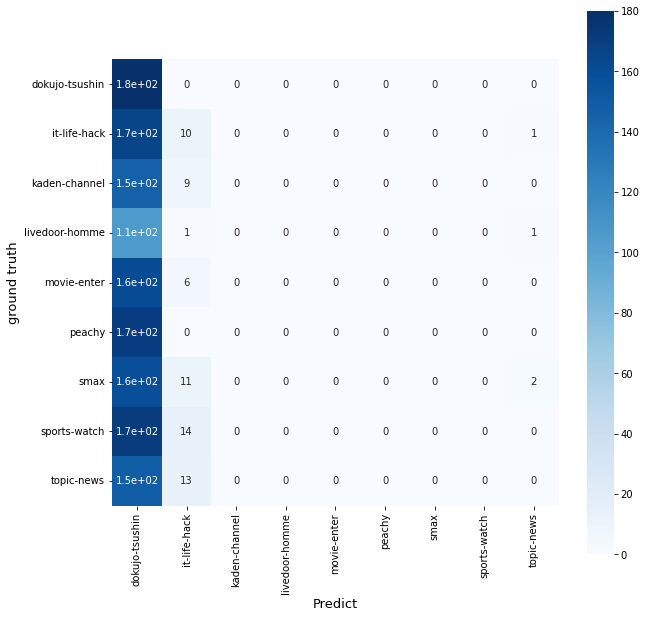

In [23]:
from sklearn.metrics import confusion_matrix
import os 
categories = [name for name in os.listdir(
    "./data/livedoor/text/") if os.path.isdir("./data/livedoor/text/"+name)]

print("カテゴリー数:", len(categories))
print(categories)

cm = confusion_matrix(test_label, preds)
cm = pd.DataFrame(data=cm, index=categories, 
                           columns=categories,)

fig = plt.figure()
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
plt.yticks(rotation=0)
plt.xlabel("Predict", fontsize=13, rotation=0)
plt.ylabel("ground truth", fontsize=13)
fig.set_figheight(10)
fig.set_figwidth(10)